<a href="https://colab.research.google.com/github/tomiambro/covid_transfer_learning/blob/main/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab
!pip install --upgrade git+https://github.com/fastai/fastai.git &> 2
!pip install pip install nbdev &> 2

# Covid detection using CT Scans

In [2]:
from fastai.vision.all import *
from torchvision import transforms as T

import gc

In [3]:
dataset_path = 'gdrive/MyDrive/machine_learning/datasets/covid_dataset'  #change dir to your project folder
folder_path = 'gdrive/MyDrive/machine_learning/covid/'

In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


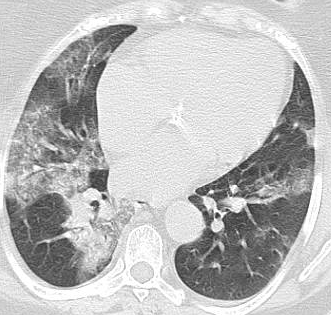

In [5]:
im = Image.open(f"{dataset_path}/COVID/Covid (1000).png")
im.to_thumb(350,350)

Create array with Path objects to imgs

In [6]:
path = Path(f"{dataset_path}")

In [7]:
imgs = get_image_files(f"{dataset_path}")
imgs[:5]

(#5) [Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1227).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1229).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1226).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1209).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1238).png')]

In [8]:
covid = DataBlock(
    blocks=(ImageBlock, CategoryBlock(['non-COVID', 'COVID'], sort=False)), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(350,350))

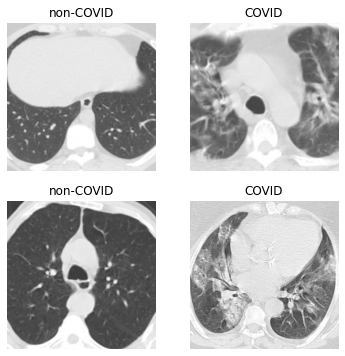

In [9]:
dls = covid.dataloaders(path)
dls.valid.show_batch(max_n=4)

In [10]:
res34 = cnn_learner(dls, resnet34, metrics=[F1Score(), Recall()], path=folder_path)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
lr = 1e-3
res34.fine_tune(4, lr, freeze_epochs=2)

epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.973855,0.487064,0.774892,0.736626,00:34
1,0.665029,0.343574,0.845018,0.942387,00:27


epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.301962,0.182833,0.919831,0.897119,00:28
1,0.193728,0.132666,0.948240,0.942387,00:29
2,0.124018,0.130145,0.948240,0.942387,00:28
3,0.089823,0.108479,0.954167,0.942387,00:28


In [12]:
df_rec34 = pd.DataFrame(res34.recorder.values, columns=['train_loss', 'valid_loss', 'f1_score', 'recall_score'])

In [13]:
df_rec34

,train_loss,valid_loss,f1_score,recall_score
0,0.301962,0.182833,0.919831,0.897119
1,0.193728,0.132666,0.948240,0.942387
2,0.124018,0.130145,0.948240,0.942387
3,0.089823,0.108479,0.954167,0.942387


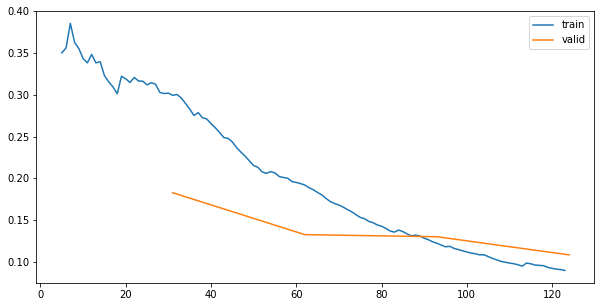

In [14]:
plt.figure(figsize=(10,5))
res34.recorder.plot_loss()

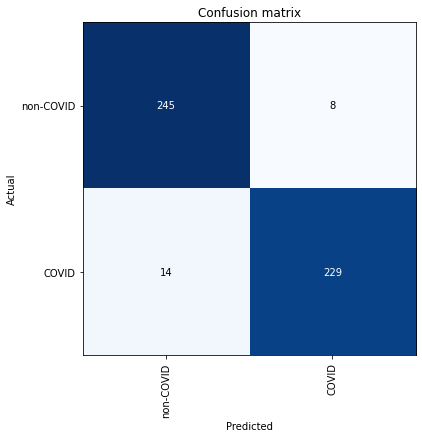

In [15]:
interp = ClassificationInterpretation.from_learner(res34)
interp.plot_confusion_matrix(figsize=(6,6))

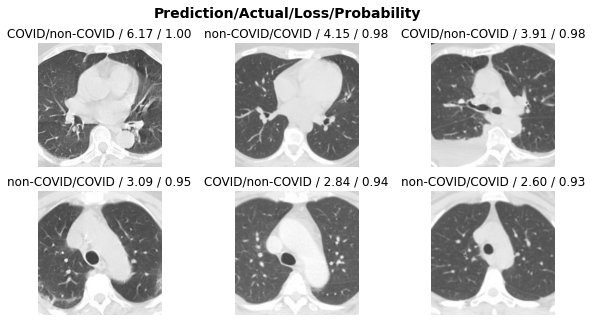

In [16]:
interp.plot_top_losses(6, figsize=(10,5))

In [17]:
res34.predict(f"{dataset_path}/COVID/Covid (1000).png")

('COVID', TensorBase(1), TensorBase([3.5214e-05, 9.9996e-01]))

In [18]:
res34.export('res34.pkl')

In [19]:
covid = covid.new(
    item_tfms=Resize(350,350),
    batch_tfms=[DeterministicFlip, Contrast(p=1, draw=1.50)])
dls = covid.dataloaders(path)

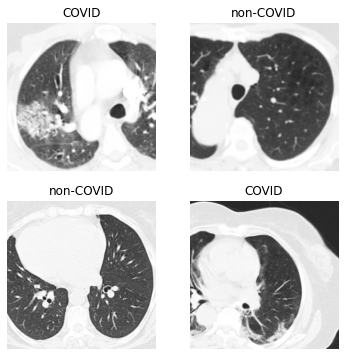

In [20]:
dls.train.show_batch(max_n=4)

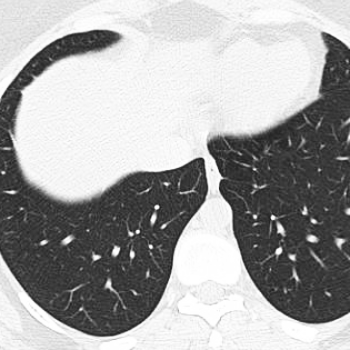

In [21]:
train_features, train_labels = next(iter(dls.train))
trans = T.ToPILImage()
trans(train_features[0])

In [22]:
res34_con = cnn_learner(dls, resnet34, metrics=[F1Score(), Recall()], path=folder_path)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
lr = 1e-3
res34_con.fine_tune(5, lr, freeze_epochs=1)

epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.790707,0.665871,0.749580,0.917695,00:26


epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.410704,0.505099,0.821678,0.967078,00:30
1,0.305946,0.195371,0.920245,0.925926,00:29
2,0.217466,0.177587,0.935223,0.950617,00:29
3,0.142187,0.165674,0.941650,0.962963,00:29
4,0.101544,0.169096,0.946108,0.975309,00:29


In [24]:
df_rec34_con = pd.DataFrame(res34_con.recorder.values, columns=['train_loss', 'valid_loss', 'f1_score', 'recall_score'])

In [25]:
df_rec34_con

,train_loss,valid_loss,f1_score,recall_score
0,0.410704,0.505099,0.821678,0.967078
1,0.305946,0.195371,0.920245,0.925926
2,0.217466,0.177587,0.935223,0.950617
3,0.142187,0.165674,0.941650,0.962963
4,0.101544,0.169096,0.946108,0.975309


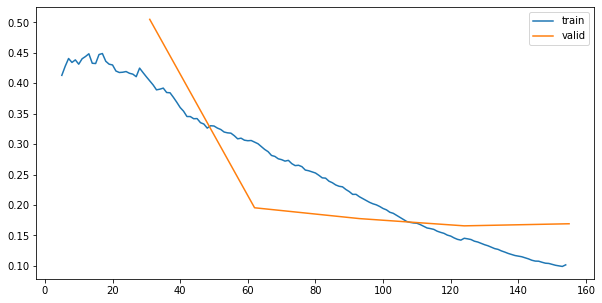

In [26]:
plt.figure(figsize=(10,5))
res34_con.recorder.plot_loss()

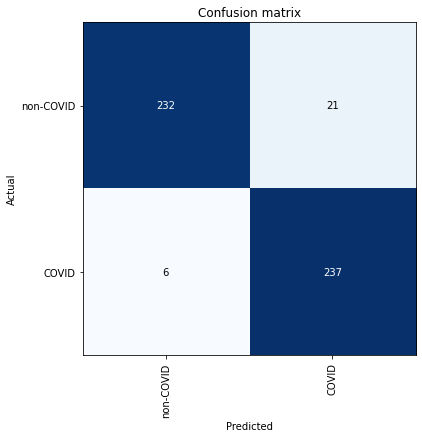

In [27]:
interp = ClassificationInterpretation.from_learner(res34_con)
interp.plot_confusion_matrix(figsize=(6,6))

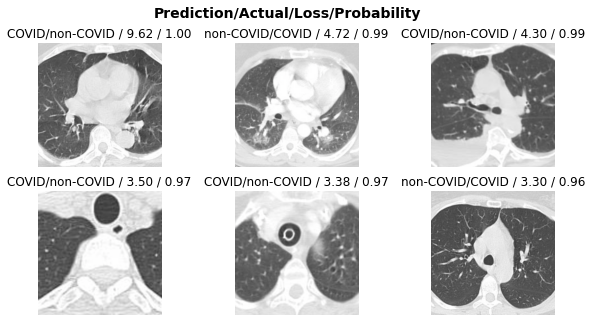

In [28]:
interp.plot_top_losses(6, figsize=(10,5))

In [29]:
res34_con.export('res34_con.pkl')

In [30]:
covid = covid.new(
    item_tfms=Resize(350,350),
    batch_tfms=[DeterministicFlip, RandomErasing(1, min_aspect=0.3, sh=0.1)])
dls = covid.dataloaders(path)

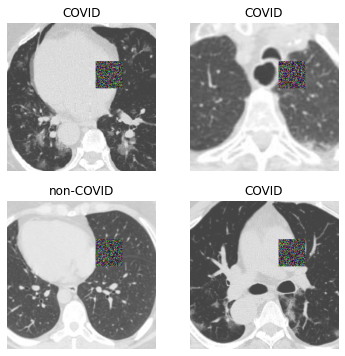

In [31]:
dls.train.show_batch(max_n=4)

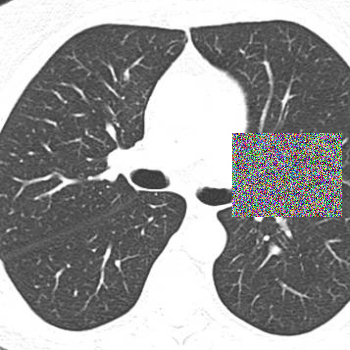

In [32]:
train_features, train_labels = next(iter(dls.train))
trans = T.ToPILImage()
trans(train_features[0])

In [33]:
res34_noise = cnn_learner(dls, resnet34, metrics=[F1Score(), Recall()], path=folder_path)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
lr = 1e-3
res34_noise.fine_tune(6, lr, freeze_epochs=2)

epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.927464,0.492757,0.784404,0.703704,00:26
1,0.691781,0.326813,0.874200,0.843621,00:26


epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.417441,0.255631,0.898305,0.872428,00:30
1,0.358208,0.155985,0.940937,0.950617,00:29
2,0.263101,0.112481,0.964948,0.962963,00:29
3,0.195639,0.104173,0.966942,0.962963,00:30
4,0.144845,0.100146,0.970833,0.958848,00:29
5,0.119134,0.103345,0.966527,0.950617,00:29


In [35]:
df_rec34_noise = pd.DataFrame(res34_noise.recorder.values, columns=['train_loss', 'valid_loss', 'f1_score', 'recall_score'])

In [36]:
df_rec34_noise

,train_loss,valid_loss,f1_score,recall_score
0,0.417441,0.255631,0.898305,0.872428
1,0.358208,0.155985,0.940937,0.950617
2,0.263101,0.112481,0.964948,0.962963
3,0.195639,0.104173,0.966942,0.962963
4,0.144845,0.100146,0.970833,0.958848
5,0.119134,0.103345,0.966527,0.950617


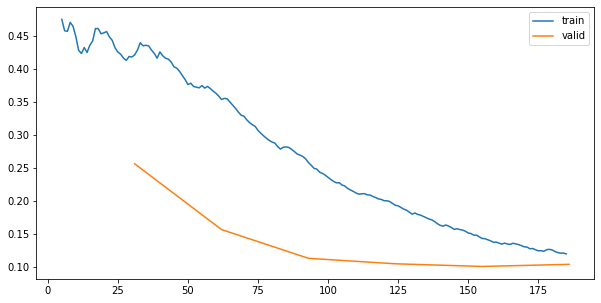

In [37]:
plt.figure(figsize=(10,5))
res34_noise.recorder.plot_loss()

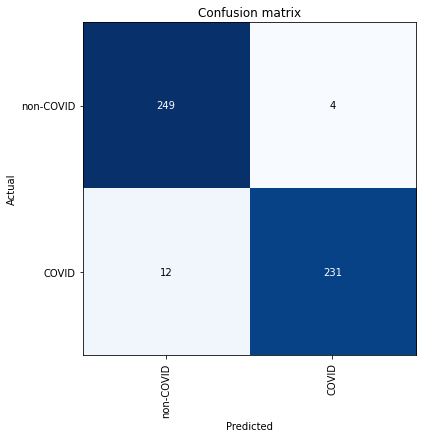

In [38]:
interp = ClassificationInterpretation.from_learner(res34_noise)
interp.plot_confusion_matrix(figsize=(6,6))

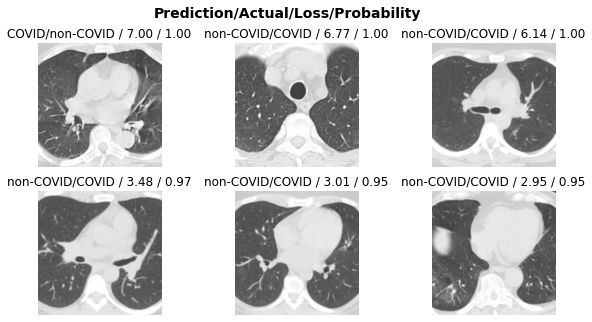

In [39]:
interp.plot_top_losses(6, figsize=(10,5))

In [40]:
res34_noise.export('res34_noise.pkl')

In [41]:
doc(Learner.get_preds)

## Inference and Ensembling

In [42]:
class Ensemble:
  def __init__(self, dls, models : dict, vocab : list=[0, 1]):
    self.models = models
    self.vocab = vocab
    self.dls = dls
    self.model_list = models.values()
    print(f'vocab: {self.vocab}')
    for name, model in models.items():
      print(f'loaded: {name}')


  def calc_probas(self, item):
    probas = []
    for _, model in self.models.items():
      _, _, p = model.predict(item)
      probas.append(p)
    
    probas = torch.stack(probas, dim=0)
    return probas

  def predict(self, item):
    probas = self.calc_probas(item)
    mean, std = probas.mean(axis=0), probas.std(axis=0)

    return self.vocab[mean.argmax()], mean.argmax(), std
  
  def get_preds(self, ds_idx=1, dl=None, with_input=False, with_decoded=False, with_loss=False, act=None, inner=False, reorder=True, cbs=None, **kwargs):
    
    if dl is None: dl = self.model_list[0].dls[1]

    predictions = []
    losses = []
    res = []

    for name, model in self.models.items():
      print(f'Getting predictions from {name}')
      inputs, preds, targs, decoded, loss = model.get_preds(dl=dls.valid, with_input=True, with_loss=True, with_decoded=True)
      predictions.append(preds)
      losses.append(loss)
    
    if with_input:
      res.append(inputs)
    
    res.append(preds)
    res.append(targs)

    if with_decoded:
      res.append(decoded)
    
    if with_loss:
      res.append(torch.stack(losses, dim=1).mean(1))
    
    print()
    preds = torch.stack(predictions).mean(0)
    decoded = preds.argmax(1)
    return tuple(res)

  def calc_metrics(self, metrics : dict):
    res = {}
    predictions, targs, decoded, losses = self.get_preds(dl=self.dls.valid, with_input=False, with_loss=True, with_decoded=True)
    for name, metric in metrics.items():
      res[name] = metric(decoded, targs)
    return res

In [43]:
en = Ensemble(dls, {'res34': res34, 'res34_con': res34_con, 'res34_noise': res34_noise}, vocab=dls.valid.vocab)
pred, mean, std = en.predict(f"{dataset_path}/COVID/Covid (1000).png")

vocab: ['non-COVID', 'COVID']
loaded: res34
loaded: res34_con
loaded: res34_noise


Prediction, probabilities and standard deviation for *item*.

In [44]:
en.predict(f"{dataset_path}/non-COVID/Non-Covid (200).png")

('non-COVID', TensorBase(0), TensorBase([0.2772, 0.2772]))

Accessing a single model from within the Ensemble

In [45]:
en.models['res34_con'].predict(f"{dataset_path}/non-COVID/Non-Covid (200).png")

('COVID', TensorBase(1), TensorBase([0.4536, 0.5464]))

In [46]:
inputs_o, predictions_o, targs_o, decoded_o, losses_o = en.models['res34'].get_preds(dl=dls.valid, with_input=True, with_loss=True, with_decoded=True)

In [47]:
predictions_o[:2], targs_o[:2], decoded_o[:2], losses_o[:2], inputs_o[:2]

(TensorBase([[9.9108e-01, 8.9237e-03],
             [2.8731e-05, 9.9997e-01]]),
 tensor([0, 1]),
 TensorBase([0, 1]),
 TensorBase([8.9638e-03, 2.8729e-05]),
 TensorImage([[[[ 1.4612,  1.4269,  1.3755,  ...,  0.0227, -0.3883, -0.6452],
                [ 1.4269,  1.4098,  1.4098,  ...,  0.6563,  0.1083, -0.2856],
                [ 1.4269,  1.4269,  1.4098,  ...,  1.2214,  0.8276,  0.5193],
                ...,
                [ 1.3755,  1.3584,  1.3584,  ...,  1.4269,  1.4269,  1.4269],
                [ 1.3927,  1.3755,  1.3755,  ...,  1.4440,  1.4440,  1.4440],
                [ 1.4098,  1.4098,  1.4098,  ...,  1.4783,  1.4783,  1.4783]],
 
               [[ 1.6232,  1.5882,  1.5357,  ...,  0.1527, -0.2675, -0.5301],
                [ 1.5882,  1.5707,  1.5707,  ...,  0.8004,  0.2402, -0.1625],
                [ 1.5882,  1.5882,  1.5707,  ...,  1.3782,  0.9755,  0.6604],
                ...,
                [ 1.5357,  1.5182,  1.5182,  ...,  1.5882,  1.5882,  1.5882],
                [ 

Calculate predictions for a whole dl

In [48]:
inputs, predictions, targs, decoded, losses = en.get_preds(dl=dls.valid, with_input=True, with_loss=True, with_decoded=True)

Getting predictions from res34


Getting predictions from res34_con


Getting predictions from res34_noise


In [49]:
predictions[:2], targs[:2], losses[:2], losses[:2], inputs[:2]

(TensorBase([[0.9560, 0.0440],
             [0.0055, 0.9945]]),
 tensor([0, 1]),
 TensorBase([0.0225, 0.0019]),
 TensorBase([0.0225, 0.0019]),
 TensorImage([[[[ 1.4612,  1.4269,  1.3755,  ...,  0.0227, -0.3883, -0.6452],
                [ 1.4269,  1.4098,  1.4098,  ...,  0.6563,  0.1083, -0.2856],
                [ 1.4269,  1.4269,  1.4098,  ...,  1.2214,  0.8276,  0.5193],
                ...,
                [ 1.3755,  1.3584,  1.3584,  ...,  1.4269,  1.4269,  1.4269],
                [ 1.3927,  1.3755,  1.3755,  ...,  1.4440,  1.4440,  1.4440],
                [ 1.4098,  1.4098,  1.4098,  ...,  1.4783,  1.4783,  1.4783]],
 
               [[ 1.6232,  1.5882,  1.5357,  ...,  0.1527, -0.2675, -0.5301],
                [ 1.5882,  1.5707,  1.5707,  ...,  0.8004,  0.2402, -0.1625],
                [ 1.5882,  1.5882,  1.5707,  ...,  1.3782,  0.9755,  0.6604],
                ...,
                [ 1.5357,  1.5182,  1.5182,  ...,  1.5882,  1.5882,  1.5882],
                [ 1.5532,  1.535

In [50]:
assert losses_o.shape == losses.shape
assert targs_o.shape == targs.shape
assert decoded_o.shape == decoded.shape
assert predictions_o.shape == predictions.shape
assert inputs_o.shape == inputs.shape

In [51]:
assert type(losses_o) == type(losses)
assert type(targs_o) == type(targs)
assert type(decoded_o) == type(decoded)
assert type(predictions_o) == type(predictions)

Calculate metrics.

In [52]:
en.calc_metrics({'F1Score': F1Score(), 'Recall': Recall()})

Getting predictions from res34


Getting predictions from res34_con


Getting predictions from res34_noise


{'F1Score': 0.9665271966527197, 'Recall': 0.9506172839506173}

In [53]:
doc(ClassificationInterpretation)

Getting predictions from res34


Getting predictions from res34_con


Getting predictions from res34_noise


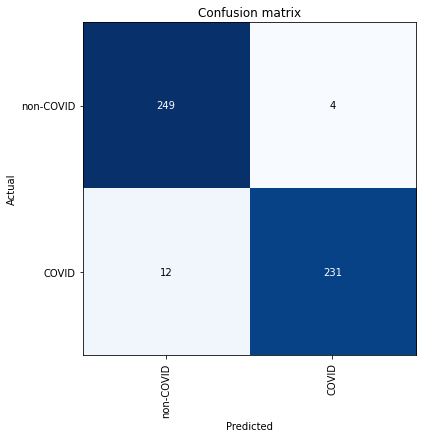

In [54]:
# interp = ClassificationInterpretation.from_learner(en, dl=dls.valid) # -> calls get_preds, but we already called it, so we pass the results instead since get_preds is computation expensive
interp = ClassificationInterpretation(en, dls.valid, losses)
interp.plot_confusion_matrix(figsize=(6,6))

In [55]:
interp.top_losses(6)

(TensorBase([7.5969, 3.7632, 2.8225, 2.7746, 2.7409, 2.3192]),
 TensorBase([340, 437, 206, 352, 233,  84]))

In [56]:
doc(ClassificationInterpretation.plot_top_losses)

Getting predictions from res34


Getting predictions from res34_con


Getting predictions from res34_noise


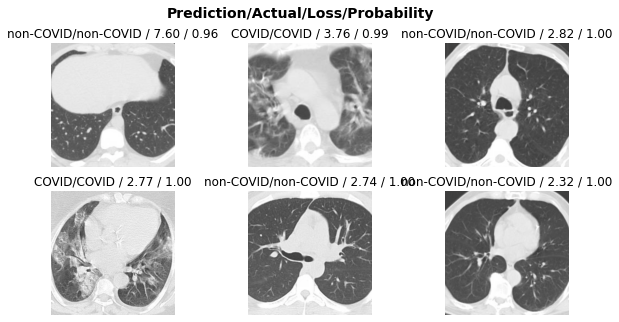

In [57]:
interp.plot_top_losses(6, figsize=(10,5))